In [2]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint
import os
import glob

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [4]:
path = "/home/aakankshaduggal/LDA/"
files = [f for f in glob.glob(path + "text.txt", recursive=True)]
print(files) 


['/home/aakankshaduggal/LDA/text.txt']


In [5]:

#Make a list
for i in range(len(files)):
    file = files[i]
    f = open(file,"r")
    if f.mode =="r":
        contents = f.read()
        print(contents)
    data = [contents.replace('\t','')]
# print(data[1])
# #Print the text of the files
# for file in files:
#     f = open(file,"r")
#     if f.mode =="r":
#       contents = f.read()
#       print(contents)

 In this Bible story from the book of Job, there is a wealthy man named Job residing in an area called Uz with his extended family and vast flocks. He is “blameless” and “upright,” constantly mindful to live in a righteous manner (Job 1:1). God brags to Satan about Job’s virtue, but Satan contends that Job is only righteous because God has favored him generously. Satan dares God that, if given the approval to inflict suffering, Job will change and curse God. God permits Satan to abuse Job to experiment with this brazen claim, but he forbids Satan to take Job’s life in the manner.

Over the time of one day, Job is given four reports, each informing him that his sheep, servants, and ten children have all died due to thieving intruders or natural disasters. Job rips his clothes and shaves his head in sorrow, yet he still praises God in his prayers. Satan arrives in heaven again, and God allows him another opportunity to test Job. This time, Job is distressed with terrible skin sores. His 

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['in', 'this', 'bible', 'story', 'from', 'the', 'book', 'of', 'job', 'there', 'is', 'wealthy', 'man', 'named', 'job', 'residing', 'in', 'an', 'area', 'called', 'uz', 'with', 'his', 'extended', 'family', 'and', 'vast', 'flocks', 'he', 'is', 'blameless', 'and', 'upright', 'constantly', 'mindful', 'to', 'live', 'in', 'righteous', 'manner', 'job', 'god', 'brags', 'to', 'satan', 'about', 'job', 'virtue', 'but', 'satan', 'contends', 'that', 'job', 'is', 'only', 'righteous', 'because', 'god', 'has', 'favored', 'him', 'generously', 'satan', 'dares', 'god', 'that', 'if', 'given', 'the', 'approval', 'to', 'inflict', 'suffering', 'job', 'will', 'change', 'and', 'curse', 'god', 'god', 'permits', 'satan', 'to', 'abuse', 'job', 'to', 'experiment', 'with', 'this', 'brazen', 'claim', 'but', 'he', 'forbids', 'satan', 'to', 'take', 'job', 'life', 'in', 'the', 'manner', 'over', 'the', 'time', 'of', 'one', 'day', 'job', 'is', 'given', 'four', 'reports', 'each', 'informing', 'him', 'that', 'his', 'sheep',

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['in', 'this', 'bible', 'story', 'from', 'the', 'book', 'of', 'job', 'there', 'is', 'wealthy', 'man', 'named', 'job', 'residing', 'in', 'an', 'area', 'called', 'uz', 'with', 'his', 'extended', 'family', 'and', 'vast', 'flocks', 'he', 'is', 'blameless', 'and', 'upright', 'constantly', 'mindful', 'to', 'live', 'in', 'righteous', 'manner', 'job', 'god', 'brags', 'to', 'satan', 'about', 'job', 'virtue', 'but', 'satan', 'contends', 'that', 'job', 'is', 'only', 'righteous', 'because', 'god', 'has', 'favored', 'him', 'generously', 'satan', 'dares', 'god', 'that', 'if', 'given', 'the', 'approval', 'to', 'inflict', 'suffering', 'job', 'will', 'change', 'and', 'curse', 'god', 'god', 'permits', 'satan', 'to', 'abuse', 'job', 'to', 'experiment', 'with', 'this', 'brazen', 'claim', 'but', 'he', 'forbids', 'satan', 'to', 'take', 'job', 'life', 'in', 'the', 'manner', 'over', 'the', 'time', 'of', 'one', 'day', 'job', 'is', 'given', 'four', 'reports', 'each', 'informing', 'him', 'that', 'his', 'sheep', 

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out


In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])



[['bible', 'story', 'book', 'job', 'wealthy', 'man', 'name', 'job', 'reside', 'area', 'call', 'uz', 'extended', 'family', 'vast', 'flock', 'blameless', 'upright', 'constantly', 'mindful', 'live', 'righteous', 'manner', 'job', 'god', 'brag', 'satan', 'job', 'virtue', 'satan', 'contend', 'job', 'righteous', 'god', 'favor', 'generously', 'satan', 'dare', 'god', 'give', 'approval', 'inflict', 'suffer', 'job', 'change', 'curse', 'god', 'god', 'permit', 'satan', 'abuse', 'job', 'experiment', 'brazen', 'claim', 'forbid', 'satan', 'take', 'job', 'life', 'manner', 'time', 'one', 'day', 'job', 'give', 'four', 'report', 'inform', 'sheep', 'servant', 'ten', 'child', 'die', 'due', 'thieve', 'intruder', 'natural', 'disaster', 'job', 'rip', 'clothe', 'shave', 'head', 'sorrow', 'yet', 'still', 'praise', 'god', 'prayer', 'satan', 'arrive', 'heaven', 'god', 'allow', 'another', 'opportunity', 'test', 'job', 'time', 'job', 'distress', 'terrible', 'skin', 'sore', 'wife', 'urge', 'denounce', 'god', 'give', 

In [10]:

print(data_lemmatized[0])

['bible', 'story', 'book', 'job', 'wealthy', 'man', 'name', 'job', 'reside', 'area', 'call', 'uz', 'extended', 'family', 'vast', 'flock', 'blameless', 'upright', 'constantly', 'mindful', 'live', 'righteous', 'manner', 'job', 'god', 'brag', 'satan', 'job', 'virtue', 'satan', 'contend', 'job', 'righteous', 'god', 'favor', 'generously', 'satan', 'dare', 'god', 'give', 'approval', 'inflict', 'suffer', 'job', 'change', 'curse', 'god', 'god', 'permit', 'satan', 'abuse', 'job', 'experiment', 'brazen', 'claim', 'forbid', 'satan', 'take', 'job', 'life', 'manner', 'time', 'one', 'day', 'job', 'give', 'four', 'report', 'inform', 'sheep', 'servant', 'ten', 'child', 'die', 'due', 'thieve', 'intruder', 'natural', 'disaster', 'job', 'rip', 'clothe', 'shave', 'head', 'sorrow', 'yet', 'still', 'praise', 'god', 'prayer', 'satan', 'arrive', 'heaven', 'god', 'allow', 'another', 'opportunity', 'test', 'job', 'time', 'job', 'distress', 'terrible', 'skin', 'sore', 'wife', 'urge', 'denounce', 'god', 'give', '

In [11]:

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 4), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 3), (36, 1), (37, 2), (38, 3), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 4), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 4), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 3), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 2), (106, 1), (107, 1), (108, 4), (109, 28), (110, 1

In [12]:

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abuse', 1),
  ('accept', 1),
  ('act', 1),
  ('actually', 1),
  ('adequately', 1),
  ('advice', 1),
  ('agree', 1),
  ('allow', 1),
  ('angry', 1),
  ('another', 1),
  ('anxious', 1),
  ('appearance', 1),
  ('approval', 1),
  ('area', 1),
  ('argue', 1),
  ('arrive', 2),
  ('assume', 1),
  ('attempt', 1),
  ('bad', 1),
  ('bear', 2),
  ('become', 1),
  ('behalf', 1),
  ('behavior', 2),
  ('believe', 2),
  ('bible', 1),
  ('bildad', 4),
  ('birth', 1),
  ('bitter', 1),
  ('blameless', 1),
  ('book', 1),
  ('brag', 1),
  ('brave', 1),
  ('brazen', 1),
  ('bring', 1),
  ('call', 2),
  ('can', 3),
  ('case', 1),
  ('change', 2),
  ('child', 3),
  ('claim', 1),
  ('clothe', 1),
  ('comfort', 2),
  ('command', 1),
  ('companion', 1),
  ('completely', 1),
  ('comprehension', 1),
  ('conceal', 1),
  ('conclude', 1),
  ('confesse', 1),
  ('confuse', 1),
  ('constantly', 1),
  ('constraint', 1),
  ('contend', 1),
  ('convince', 1),
  ('creation', 1),
  ('curse', 1),
  ('damns', 1),
  ('dare'

In [13]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [14]:

# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]



[(0,
  '0.004*"job" + 0.004*"god" + 0.004*"human" + 0.004*"satan" + 0.004*"give" + '
  '0.004*"eliphaz" + 0.004*"people" + 0.004*"day" + 0.004*"suffer" + '
  '0.004*"not"'),
 (1,
  '0.004*"property" + 0.004*"prayer" + 0.004*"recognize" + 0.004*"react" + '
  '0.004*"question" + 0.004*"provoke" + 0.004*"protest" + 0.004*"reconcile" + '
  '0.004*"possibly" + 0.004*"poetic"'),
 (2,
  '0.004*"god" + 0.004*"job" + 0.004*"satan" + 0.004*"human" + 0.004*"suffer" '
  '+ 0.004*"day" + 0.004*"eliphaz" + 0.004*"give" + 0.004*"zophar" + '
  '0.004*"bildad"'),
 (3,
  '0.004*"property" + 0.004*"prayer" + 0.004*"recognize" + 0.004*"react" + '
  '0.004*"question" + 0.004*"provoke" + 0.004*"protest" + 0.004*"reconcile" + '
  '0.004*"possibly" + 0.004*"poetic"'),
 (4,
  '0.004*"job" + 0.004*"god" + 0.004*"people" + 0.004*"satan" + 0.004*"suffer" '
  '+ 0.004*"bildad" + 0.004*"human" + 0.004*"day" + 0.004*"give" + '
  '0.004*"eliphaz"'),
 (5,
  '0.011*"job" + 0.007*"god" + 0.005*"satan" + 0.004*"people" +

In [15]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -6.601535240044961
Coherence Score:  0.26954970511326065


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)


/home/aakankshaduggal/env/lib64/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/aakankshaduggal/Downloads/mallet-2.0.8/bin/mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)



In [22]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('desire', 0.2),
   ('easily', 0.1),
   ('contend', 0.1),
   ('power', 0.1),
   ('explain', 0.1),
   ('eventually', 0.1),
   ('test', 0.1),
   ('defend', 0.1),
   ('terrible', 0.1),
   ('react', 0.0)]),
 (1,
  [('eliphaz', 0.18181818181818182),
   ('evil', 0.13636363636363635),
   ('wisdom', 0.09090909090909091),
   ('due', 0.09090909090909091),
   ('experienced', 0.045454545454545456),
   ('mysterious', 0.045454545454545456),
   ('remark', 0.045454545454545456),
   ('trouble', 0.045454545454545456),
   ('intruder', 0.045454545454545456),
   ('increase', 0.045454545454545456)]),
 (2,
  [('pain', 0.14285714285714285),
   ('reside', 0.07142857142857142),
   ('scared', 0.07142857142857142),
   ('end', 0.07142857142857142),
   ('inflict', 0.07142857142857142),
   ('generously', 0.07142857142857142),
   ('approval', 0.07142857142857142),
   ('protest', 0.07142857142857142),
   ('space', 0.07142857142857142),
   ('word', 0.07142857142857142)]),
 (3,
  [('job', 0.7692307692307693),
  

In [23]:


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



In [24]:


# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)



Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


/home/aakankshaduggal/env/lib64/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:380: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


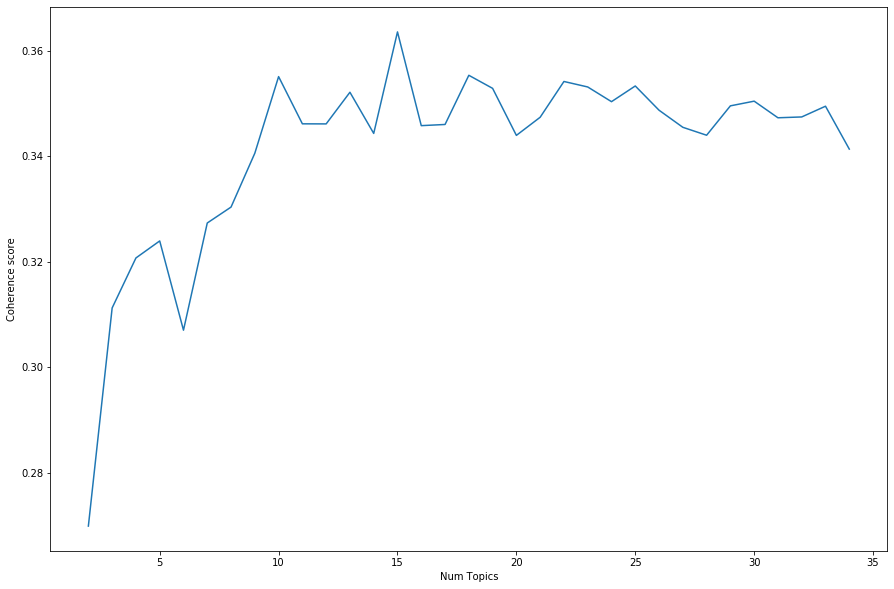

In [25]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()


In [26]:


# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))



Num Topics = 2  has Coherence Value of 0.269875
Num Topics = 3  has Coherence Value of 0.311247
Num Topics = 4  has Coherence Value of 0.320728
Num Topics = 5  has Coherence Value of 0.323956
Num Topics = 6  has Coherence Value of 0.307031
Num Topics = 7  has Coherence Value of 0.32736
Num Topics = 8  has Coherence Value of 0.33038
Num Topics = 9  has Coherence Value of 0.340595
Num Topics = 10  has Coherence Value of 0.355124
Num Topics = 11  has Coherence Value of 0.34617
Num Topics = 12  has Coherence Value of 0.346154
Num Topics = 13  has Coherence Value of 0.352157
Num Topics = 14  has Coherence Value of 0.344348
Num Topics = 15  has Coherence Value of 0.363602
Num Topics = 16  has Coherence Value of 0.345824
Num Topics = 17  has Coherence Value of 0.346046
Num Topics = 18  has Coherence Value of 0.355374
Num Topics = 19  has Coherence Value of 0.352898
Num Topics = 20  has Coherence Value of 0.343978
Num Topics = 21  has Coherence Value of 0.347416
Num Topics = 22  has Coherence 

In [27]:


# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 10
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))



[(0,
  '0.182*"give" + 0.091*"righteous" + 0.045*"confuse" + 0.045*"favor" + '
  '0.045*"suggest" + 0.045*"possibly" + 0.045*"bad" + 0.045*"start" + '
  '0.045*"seventh" + 0.045*"remark"'),
 (1,
  '0.147*"human" + 0.059*"endure" + 0.059*"change" + 0.059*"comfort" + '
  '0.059*"call" + 0.059*"forgive" + 0.029*"obscure" + 0.029*"experienced" + '
  '0.029*"extended" + 0.029*"sheep"'),
 (2,
  '0.426*"job" + 0.298*"god" + 0.043*"eliphaz" + 0.021*"heaven" + '
  '0.011*"property" + 0.011*"bitter" + 0.011*"generously" + 0.011*"live" + '
  '0.011*"poetic" + 0.011*"upright"'),
 (3,
  '0.235*"day" + 0.235*"zophar" + 0.059*"experiment" + 0.059*"sorrow" + '
  '0.059*"creation" + 0.059*"emit" + 0.059*"trouble" + 0.059*"health" + '
  '0.059*"reside" + 0.059*"sore"'),
 (4,
  '0.091*"due" + 0.045*"feature" + 0.045*"recognize" + 0.045*"honest" + '
  '0.045*"understanding" + 0.045*"grieve" + 0.045*"grant" + 0.045*"prayer" + '
  '0.045*"attempt" + 0.045*"sin"'),
 (5,
  '0.194*"satan" + 0.129*"life" + 0.06

In [28]:
optimal_model.show_topic(0,10)

[('give', 0.18181818181818182),
 ('righteous', 0.09090909090909091),
 ('confuse', 0.045454545454545456),
 ('favor', 0.045454545454545456),
 ('suggest', 0.045454545454545456),
 ('possibly', 0.045454545454545456),
 ('bad', 0.045454545454545456),
 ('start', 0.045454545454545456),
 ('seventh', 0.045454545454545456),
 ('remark', 0.045454545454545456)]

In [29]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['give', 'righteous', 'confuse', 'favor', 'suggest', 'possibly', 'bad', 'start', 'seventh', 'remark']
Topic 1: ['human', 'endure', 'change', 'comfort', 'call', 'forgive', 'obscure', 'experienced', 'extended', 'sheep']
Topic 2: ['job', 'god', 'eliphaz', 'heaven', 'property', 'bitter', 'generously', 'live', 'poetic', 'upright']
Topic 3: ['day', 'zophar', 'experiment', 'sorrow', 'creation', 'emit', 'trouble', 'health', 'reside', 'sore']
Topic 4: ['due', 'feature', 'recognize', 'honest', 'understanding', 'grieve', 'grant', 'prayer', 'attempt', 'sin']
Topic 5: ['satan', 'life', 'desire', 'wisdom', 'evade', 'command', 'completely', 'constantly', 'sit', 'detailed']
Topic 6: ['behavior', 'man', 'justice', 'find', 'blameless', 'persevere', 'clothe', 'injustice', 'shave', 'defend']
Topic 7: ['darkness', 'whitewash', 'family', 'silence', 'inflict', 'claim', 'report', 'mysterious', 'bring', 'upset']
Topic 8: ['bildad', 'suffer', 'death', 'time', 'bear', 'suffering', 'arrive', 'manner', 'd

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.2426,"job, god, eliphaz, heaven, property, bitter, g...","In this Bible story from the book of Job, the..."


In [31]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text


In [32]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['job,',
  'god,',
  'eliphaz,',
  'heaven,',
  'property,',
  'bitter,',
  'generously,',
  'live,',
  'poetic,',
  'upright']]

In [33]:


for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))



0. Dominant keywords: ['job', 'god', 'eliphaz', 'heaven', 'property']


In [34]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,2.0,0.2426,"job, god, eliphaz, heaven, property, bitter, g...","In this Bible story from the book of Job, the..."


In [35]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 2
Keywords: job, god, eliphaz, heaven, property, bitter, generously, live, poetic, upright

 In this Bible story from the book of Job, there is a wealthy man named Job residing in an area called Uz with his extended family and vast flocks. He is “blameless” and “upright,” constantly mindful to live in a righteous manner (Job 1:1). God brags to Satan about Job’s virtue, but Satan contends that Job is only righteous because God has favored him generously. Satan dares God that, if given the approval to inflict suffering, Job will change and curse God. God permits Satan to abuse Job to experiment with this brazen claim, but he forbids Satan to take Job’s life in the manner.

Over the time of one day, Job is given four reports, each informing him that his sheep, servants, and ten children have all died due to thieving intruders or natural disasters. Job rips his clothes and shaves his head in sorrow, yet he still praises God in his prayers. Satan arrives in heaven again, and Go

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,2.0,"job, god, eliphaz, heaven, property, bitter, g...",NaN,NaN
2.0,NaN,NaN,1.0,1.0


In [37]:


with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)



,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,2.0,"job, god, eliphaz, heaven, property, bitter, generously, live, poetic, upright",NaN,NaN
2.0,NaN,NaN,1.0,1.0


In [38]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)